In [203]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [204]:
dc=pd.read_csv('doctor_information.csv')
pt=pd.read_csv('patient_information.csv')
apt=pd.read_csv('appointments.csv')

<Axes: xlabel='Rating'>

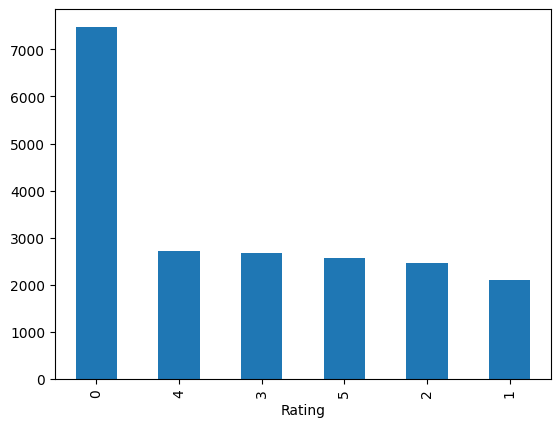

In [205]:
apt['Rating'].value_counts().plot(kind='bar')

In [232]:
mincount=min(apt['Rating'].value_counts())

In [206]:
# take equal number of samples from each class

apt=apt.groupby('Rating').apply(lambda x: x.sample(mincount,replace=True)).reset_index(drop=True)

# shuffle the data

apt=apt.sample(frac=1).reset_index(drop=True)

<Axes: xlabel='Rating'>

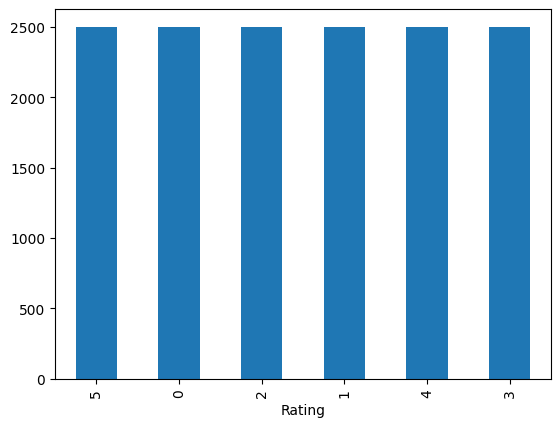

In [207]:
apt['Rating'].value_counts().plot(kind='bar')

In [208]:
dc.describe()

,ID,Age,Type,Experience,Hospital Location,Patients in Queue,Patients Seen in Lifetime
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,7760.760210,54.933190,50.453050,14.971910,950.023910,15.537560,5505.415220
std,4184.189546,14.751454,28.879966,8.943474,29.193538,8.674896,2597.791948
min,500.000000,30.000000,1.000000,0.000000,900.000000,1.000000,1000.000000
25%,4132.000000,42.000000,25.000000,7.000000,925.000000,8.000000,3258.000000
50%,7771.000000,55.000000,50.000000,15.000000,950.000000,16.000000,5504.000000
75%,11391.250000,68.000000,76.000000,23.000000,975.000000,23.000000,7753.000000
max,15000.000000,80.000000,100.000000,30.000000,1000.000000,30.000000,10000.000000


In [209]:
pt.describe()

,ID,Age,Gender,Health Condition,Hospital Location,Preferred Doctor Type,Last Appointment
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2997.029940,53.861420,1.501420,50.704980,950.039840,50.557780,183.981020
std,1158.672088,21.060809,0.500003,28.845212,29.068846,28.957266,105.450938
min,1000.000000,18.000000,1.000000,1.000000,900.000000,1.000000,1.000000
25%,1991.000000,36.000000,1.000000,26.000000,925.000000,26.000000,92.000000
50%,2992.000000,54.000000,2.000000,51.000000,950.000000,51.000000,185.000000
75%,4000.250000,72.000000,2.000000,76.000000,975.000000,76.000000,276.000000
max,5000.000000,90.000000,2.000000,100.000000,1000.000000,100.000000,365.000000


In [210]:
apt.describe()

,AppointmentID,PatientID,DoctorID,AppointmentDate,Rating
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,10034.118467,3013.968400,7788.113933,183.546733,2.500000
std,5777.837419,1157.464513,4194.955181,105.978216,1.707882
min,3.000000,1000.000000,500.000000,1.000000,0.000000
25%,5122.000000,2009.750000,4193.000000,93.000000,1.000000
50%,10035.500000,2995.000000,7781.000000,183.000000,2.500000
75%,15033.000000,4041.250000,11412.000000,277.000000,4.000000
max,20000.000000,5000.000000,15000.000000,365.000000,5.000000


In [211]:
# find if every appointment has a doctor and a patient whose information is available

apt['DoctorID'].isin(dc['ID']).value_counts()
apt['PatientID'].isin(pt['ID']).value_counts()

PatientID
True    15000
Name: count, dtype: int64

In [212]:
docs=np.array(dc['ID'])
pts=np.array(pt['ID'])

In [213]:
docs[0]
pts[0]

2335

In [214]:
# use this to create x values for the model which will be a list of lists of the form [[doctor information],[patient information]]

doctor_info = []
patient_info = []

for i in range(len(apt)):
    inf_doc = dc[dc['ID'] == apt['DoctorID'][i]]
    inf_pt = pt[pt['ID'] == apt['PatientID'][i]]
    inf_doc = inf_doc.values[0]                         #there is a problem here
    inf_pt = inf_pt.values[0]                            #there is a problem here
    doctor_info.append(inf_doc)
    patient_info.append(inf_pt)

doctor_info = np.array(doctor_info)
patient_info = np.array(patient_info)

y = apt['Rating'].values.tolist()

In [215]:
# normalize the data

doctor_info = (doctor_info - np.mean(doctor_info))/np.std(doctor_info)
patient_info = (patient_info - np.mean(patient_info))/np.std(patient_info)

In [216]:
doctor_info[0]

array([-0.21689656, -0.56054276, -0.57162812, -0.57844988, -0.30415825,
       -0.58043956,  0.76600548])

In [217]:
patient_info[0]

array([ 3.90560081, -0.52659563, -0.54807639, -0.49616456,  0.27535268,
       -0.54718136, -0.23123521])

In [218]:
# create training and testing data

train_size = int(0.8*len(doctor_info))
test_size = len(doctor_info) - train_size

train_doctor_info = doctor_info[:train_size]
train_patient_info = patient_info[:train_size]
train_doctor_info=np.array(train_doctor_info)
train_patient_info=np.array(train_patient_info)
train_y=np.array(y[:train_size])

train_x=tf.data.Dataset.from_tensor_slices((train_doctor_info,train_patient_info))
train_y=tf.data.Dataset.from_tensor_slices(train_y)
train_data=tf.data.Dataset.zip((train_x,train_y))
train_data=train_data.batch(32)

test_doctor_info = doctor_info[train_size:]
test_patient_info = patient_info[train_size:]
test_doctor_info=np.array(test_doctor_info)
test_patient_info=np.array(test_patient_info)
test_y=np.array(y[train_size:])

test_x=tf.data.Dataset.from_tensor_slices((test_doctor_info,test_patient_info))
test_y=tf.data.Dataset.from_tensor_slices(test_y)
test_data=tf.data.Dataset.zip((test_x,test_y))
test_data=test_data.batch(32)

In [219]:
def create_model(hp):
    lr=hp.Float('learning_rate',min_value=1e-6,max_value=1e-1,sampling='LOG',default=1e-3)
    unit1=hp.Int('unit1',min_value=32,max_value=128,step=32)
    unit2=hp.Int('unit2',min_value=32,max_value=64,step=32)
    unit3=hp.Int('unit3',min_value=32,max_value=64,step=32)
    unit4=hp.Int('unit4',min_value=16,max_value=32,step=32)
    input1=tf.keras.layers.Input(shape=(7,))
    input2=tf.keras.layers.Input(shape=(7,))

    a=tf.keras.layers.Dense(unit1,activation='relu')(input1)
    b=tf.keras.layers.Dense(unit1,activation='relu')(input2)

    b=tf.keras.layers.Dense(unit2,activation='relu')(b)
    a=tf.keras.layers.Dense(unit2,activation='relu')(a)

    a=tf.keras.layers.Dense(unit3,activation='relu')(a)
    b=tf.keras.layers.Dense(unit3,activation='relu')(b)

    c=tf.keras.layers.add([a,b])

    c=tf.keras.layers.Dense(unit4,activation='relu')(c)
    c=tf.keras.layers.Dense(11,activation='softmax')(c)

    model=tf.keras.models.Model(inputs=[input1,input2],outputs=c)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

    return model

In [220]:
# tune the hyperparameters

import keras_tuner as kt

tuner=kt.Hyperband(create_model,objective='val_accuracy',max_epochs=10,overwrite=True,project_name='doctor_patient')

In [221]:
tuner.search(train_data,epochs=10,validation_data=test_data)

Trial 30 Complete [00h 00m 06s]
val_accuracy: 0.18266665935516357

Best val_accuracy So Far: 0.18266665935516357
Total elapsed time: 00h 01m 38s


In [222]:
model = tuner.get_best_models()[0]

In [223]:
# plot the model

tf.keras.utils.plot_model(model,show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [224]:
# import the callbacks

from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau

checkpoint=ModelCheckpoint('model.h5',monitor='loss',save_best_only=True)

earlystop=EarlyStopping(monitor='loss',patience=10)

reduce_lr=ReduceLROnPlateau(monitor='loss',factor=0.2,patience=1,min_lr=1e-6)


In [225]:
model.fit(train_data,epochs=50,callbacks=[checkpoint,earlystop,reduce_lr])

Epoch 1/50


375/375 [==============================] - 1s 1ms/step - loss: 1.7925 - accuracy: 0.1688 - lr: 0.0010
Epoch 2/50
375/375 [==============================] - 0s 980us/step - loss: 1.7922 - accuracy: 0.1689 - lr: 0.0010
Epoch 3/50
375/375 [==============================] - 0s 980us/step - loss: 1.7921 - accuracy: 0.1708 - lr: 0.0010
Epoch 4/50
375/375 [==============================] - 0s 980us/step - loss: 1.7917 - accuracy: 0.1724 - lr: 0.0010
Epoch 5/50
375/375 [==============================] - 0s 981us/step - loss: 1.7916 - accuracy: 0.1734 - lr: 0.0010
Epoch 6/50
375/375 [==============================] - 0s 1ms/step - loss: 1.7897 - accuracy: 0.1839 - lr: 2.0000e-04
Epoch 7/50
375/375 [==============================] - 0s 982us/step - loss: 1.7891 - accuracy: 0.1822 - lr: 2.0000e-04
Epoch 8/50
375/375 [==============================] - 0s 980us/step - loss: 1.7890 - accuracy: 0.1827 - lr: 2.0000e-04
Epoch 9/50
375/375 [==============================] - 0s 1ms/step - loss: 1.7889 - 

In [226]:
# test the model
y_pred=model.predict(test_data)

94/94 [==============================] - 0s 744us/step


In [227]:
y_pred=np.array(y_pred)

In [228]:
y_pred=np.argmax(y_pred,axis=1)

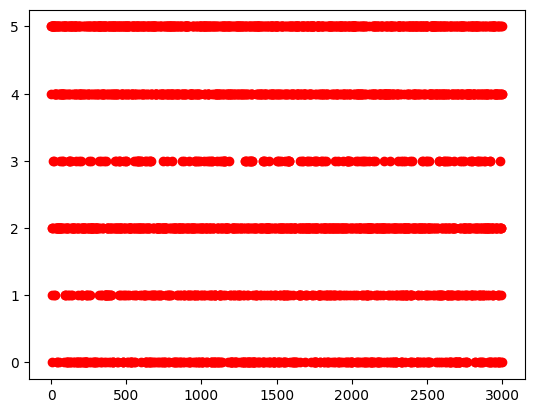

In [229]:
plt.scatter(range(len(y_pred)),y_pred,color='red')

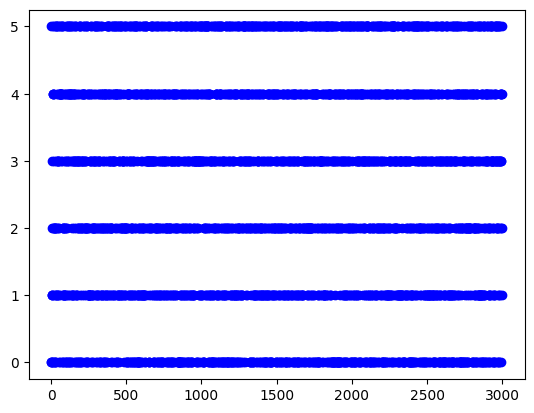

In [230]:
plt.scatter(range(len(np.array(y[train_size:]))),np.array(y[train_size:]),color='blue')

<Axes: >

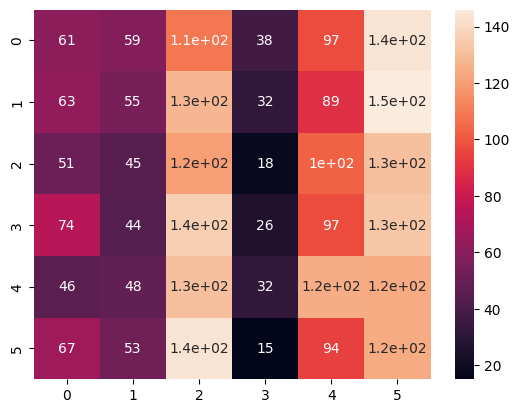

In [231]:
# confusion matrix in heat map

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(np.array(y[train_size:]),y_pred)

import seaborn as sns
sns.heatmap(cm,annot=True)